# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomResizedCrop(28),                                    
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.RandomAffine( degrees =0,translate=(0.1,0.1), scale=(0.9, 1.1),shear=(-10, 10, 20, 40)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(dropout_value)
        ) # output_size = 26 
        #o/p size=16*26*26 RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 24 
        #o/p size=32*24*24 RF=5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        #o/p size=10*24*24 RF=5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
         #o/p size=10*12*12 RF=6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 10
        #o/p size =16*10*10 RF=10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 8
        #o/p size = 16*8*8 RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        #o/p size = 16*6*6 RF = 18
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        #o/p size = 16*6*6 RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        #o/p size = 16*1*1 RF = 32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 
        #o/p size = 10*1*1 RF = 32


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,168
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5            [-1, 8, 24, 24]             128
         MaxPool2d-6            [-1, 8, 12, 12]               0
            Conv2d-7           [-1, 16, 10, 10]           1,152
              ReLU-8           [-1, 16, 10, 10]               0
       BatchNorm2d-9           [-1, 16, 10, 10]              32
           Conv2d-10             [-1, 16, 8, 8]           2,304
             ReLU-11             [-1, 16, 8, 8]               0
      BatchNorm2d-12             [-1, 16, 8, 8]              32
           Conv2d-13             [-1, 16, 6, 6]           2,304
             ReLU-14             [

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08579053729772568 Batch_id=468 Accuracy=92.13: 100%|██████████████████████████| 469/469 [00:12<00:00, 37.09it/s]



Test set: Average loss: 0.0950, Accuracy: 9721/10000 (97.21%)

EPOCH: 1


Loss=0.015452046878635883 Batch_id=468 Accuracy=97.84: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.34it/s]



Test set: Average loss: 0.0489, Accuracy: 9843/10000 (98.43%)

EPOCH: 2


Loss=0.0775863453745842 Batch_id=468 Accuracy=98.47: 100%|███████████████████████████| 469/469 [00:12<00:00, 38.90it/s]



Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.09544200450181961 Batch_id=468 Accuracy=98.59: 100%|██████████████████████████| 469/469 [00:12<00:00, 37.53it/s]



Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.03929854556918144 Batch_id=468 Accuracy=98.89: 100%|██████████████████████████| 469/469 [00:12<00:00, 38.82it/s]



Test set: Average loss: 0.0271, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.0232686847448349 Batch_id=468 Accuracy=98.90: 100%|███████████████████████████| 469/469 [00:12<00:00, 38.68it/s]



Test set: Average loss: 0.0227, Accuracy: 9937/10000 (99.37%)

EPOCH: 6


Loss=0.06160658225417137 Batch_id=468 Accuracy=98.98: 100%|██████████████████████████| 469/469 [00:12<00:00, 38.58it/s]



Test set: Average loss: 0.0264, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.010295510292053223 Batch_id=468 Accuracy=98.99: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.77it/s]



Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 8


Loss=0.02752053737640381 Batch_id=468 Accuracy=99.07: 100%|██████████████████████████| 469/469 [00:11<00:00, 39.27it/s]



Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.017037836834788322 Batch_id=468 Accuracy=99.16: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.86it/s]



Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.049270689487457275 Batch_id=468 Accuracy=99.11: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.65it/s]



Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.004036203026771545 Batch_id=468 Accuracy=99.18: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.59it/s]



Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.017451032996177673 Batch_id=468 Accuracy=99.23: 100%|█████████████████████████| 469/469 [00:12<00:00, 39.06it/s]



Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.02829860709607601 Batch_id=468 Accuracy=99.22: 100%|██████████████████████████| 469/469 [00:11<00:00, 39.10it/s]



Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.04300318658351898 Batch_id=468 Accuracy=99.23: 100%|██████████████████████████| 469/469 [00:12<00:00, 38.45it/s]



Test set: Average loss: 0.0196, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.029473373666405678 Batch_id=468 Accuracy=99.32: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.02it/s]



Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.0129711227491498 Batch_id=468 Accuracy=99.29: 100%|███████████████████████████| 469/469 [00:12<00:00, 43.32it/s]



Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.08490762114524841 Batch_id=468 Accuracy=99.33: 100%|██████████████████████████| 469/469 [00:12<00:00, 38.00it/s]



Test set: Average loss: 0.0181, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Loss=0.005722895264625549 Batch_id=468 Accuracy=99.35: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.98it/s]



Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.022777145728468895 Batch_id=468 Accuracy=99.39: 100%|█████████████████████████| 469/469 [00:12<00:00, 37.66it/s]



Test set: Average loss: 0.0163, Accuracy: 9948/10000 (99.48%)

EPOCH: 20


Loss=0.014474143274128437 Batch_id=468 Accuracy=99.38: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.82it/s]



Test set: Average loss: 0.0185, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.06885971873998642 Batch_id=468 Accuracy=99.40: 100%|██████████████████████████| 469/469 [00:11<00:00, 39.24it/s]



Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.08194946497678757 Batch_id=468 Accuracy=99.41: 100%|██████████████████████████| 469/469 [00:11<00:00, 40.32it/s]



Test set: Average loss: 0.0141, Accuracy: 9958/10000 (99.58%)

EPOCH: 23


Loss=0.020538872107863426 Batch_id=468 Accuracy=99.43: 100%|█████████████████████████| 469/469 [00:11<00:00, 45.42it/s]



Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.009427745826542377 Batch_id=468 Accuracy=99.41: 100%|█████████████████████████| 469/469 [00:11<00:00, 39.23it/s]



Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 25


Loss=0.010147452354431152 Batch_id=468 Accuracy=99.47: 100%|█████████████████████████| 469/469 [00:11<00:00, 39.70it/s]



Test set: Average loss: 0.0164, Accuracy: 9951/10000 (99.51%)

EPOCH: 26


Loss=0.001704484224319458 Batch_id=468 Accuracy=99.44: 100%|█████████████████████████| 469/469 [00:11<00:00, 39.17it/s]



Test set: Average loss: 0.0161, Accuracy: 9946/10000 (99.46%)

EPOCH: 27


Loss=0.01241630781441927 Batch_id=468 Accuracy=99.47: 100%|██████████████████████████| 469/469 [00:12<00:00, 38.95it/s]



Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.004312118049710989 Batch_id=468 Accuracy=99.42: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.45it/s]



Test set: Average loss: 0.0161, Accuracy: 9943/10000 (99.43%)

EPOCH: 29


Loss=0.004172647837549448 Batch_id=468 Accuracy=99.47: 100%|█████████████████████████| 469/469 [00:11<00:00, 39.16it/s]



Test set: Average loss: 0.0162, Accuracy: 9951/10000 (99.51%)

EPOCH: 30


Loss=0.012054751627147198 Batch_id=468 Accuracy=99.45: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.64it/s]



Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)

EPOCH: 31


Loss=0.005753020290285349 Batch_id=468 Accuracy=99.50: 100%|█████████████████████████| 469/469 [00:12<00:00, 37.96it/s]



Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)

EPOCH: 32


Loss=0.028194034472107887 Batch_id=468 Accuracy=99.50: 100%|█████████████████████████| 469/469 [00:11<00:00, 39.13it/s]



Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

EPOCH: 33


Loss=0.060168806463479996 Batch_id=468 Accuracy=99.55: 100%|█████████████████████████| 469/469 [00:11<00:00, 39.37it/s]



Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 34


Loss=0.003112624166533351 Batch_id=468 Accuracy=99.55: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.65it/s]



Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH: 35


Loss=0.019212305545806885 Batch_id=468 Accuracy=99.54: 100%|█████████████████████████| 469/469 [00:12<00:00, 37.83it/s]



Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 36


Loss=0.025532448664307594 Batch_id=468 Accuracy=99.52: 100%|█████████████████████████| 469/469 [00:11<00:00, 45.36it/s]



Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 37


Loss=0.04160253331065178 Batch_id=468 Accuracy=99.52: 100%|██████████████████████████| 469/469 [00:12<00:00, 38.69it/s]



Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH: 38


Loss=0.002456004498526454 Batch_id=468 Accuracy=99.55: 100%|█████████████████████████| 469/469 [00:12<00:00, 38.01it/s]



Test set: Average loss: 0.0145, Accuracy: 9954/10000 (99.54%)

EPOCH: 39


Loss=0.015216653235256672 Batch_id=468 Accuracy=99.57: 100%|█████████████████████████| 469/469 [00:12<00:00, 37.83it/s]



Test set: Average loss: 0.0173, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

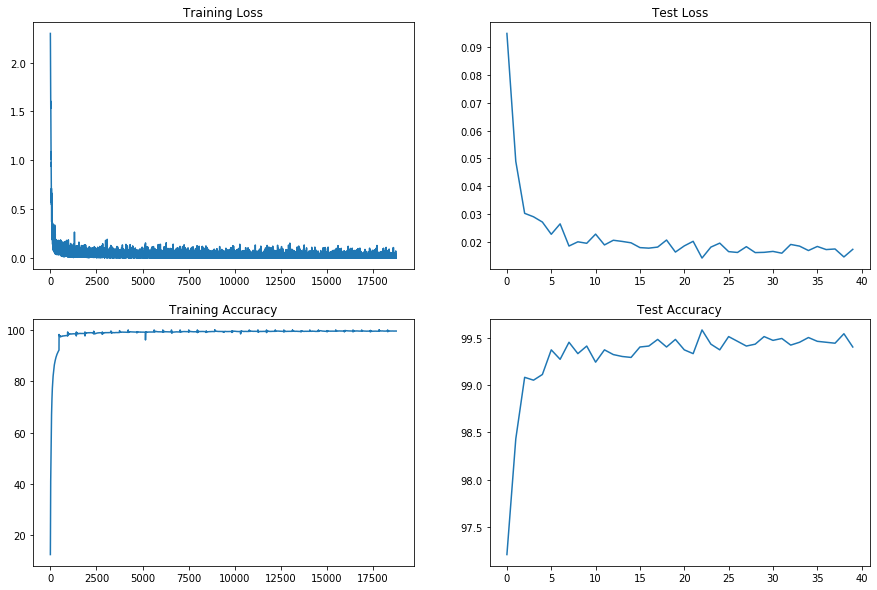

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")